In [1]:
#libraries needed
import json
import pymongo
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.mlab as mlab
import requests
import datetime
import schedule
import time
import datetime
from geopy.distance import vincenty
import numpy
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


C:\Users\ybellalah\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
# To scrape data from JCDecaux API automatically every 10 minutes

client = MongoClient()
client = MongoClient('localhost', 27017)
db = client.velib # database
collection = db.clean #collection



def rec():
    url = "https://api.jcdecaux.com/vls/v1/stations?contract=dublin&apiKey=da879af595184f071c181408b837b7da636f924f"
    resp = requests.get(url=url)
    data = resp.json()
    collection.insert_many(data)
    
    
schedule.every(10).minutes.do(rec) 
while True:
    schedule.run_pending()



In [2]:
#connecting to  mongodb localhost
from pymongo import MongoClient
client = MongoClient()
client = MongoClient('localhost', 27017)

#connecting  to database and collection
db = client.velib
dublin=db.clean

In [4]:
# converting data into dataframe
dataf=pd.DataFrame(list(dublin.find()))
#transform date format from timestamp to date format 
dataf['last_update']= pd.to_datetime(dataf['last_update'],unit='ms')
dataf["banking"]=dataf["banking"].astype('category')
dataf["banking"]=dataf["banking"].cat.codes
print(dataf.shape)
dataf.head()


(28500, 13)


,_id,address,available_bike_stands,available_bikes,banking,bike_stands,bonus,contract_name,last_update,name,number,position,status
0,5c01372df8b77f2750eb57c2,Smithfield North,26,4,1,30,False,Dublin,2018-11-30 13:03:35,SMITHFIELD NORTH,42,"{'lat': 53.349562, 'lng': -6.278198}",OPEN
1,5c01372df8b77f2750eb57c3,Parnell Square North,12,8,1,20,False,Dublin,2018-11-30 13:02:10,PARNELL SQUARE NORTH,30,"{'lat': 53.353462, 'lng': -6.265305}",OPEN
2,5c01372df8b77f2750eb57c4,Clonmel Street,15,18,0,33,False,Dublin,2018-11-30 13:07:29,CLONMEL STREET,54,"{'lat': 53.336021, 'lng': -6.26298}",OPEN
3,5c01372df8b77f2750eb57c5,Avondale Road,38,1,0,40,False,Dublin,2018-11-30 13:05:48,AVONDALE ROAD,108,"{'lat': 53.359405, 'lng': -6.276142}",OPEN
4,5c01372df8b77f2750eb57c6,Mount Street Lower,14,26,0,40,False,Dublin,2018-11-30 13:11:57,MOUNT STREET LOWER,56,"{'lat': 53.33796, 'lng': -6.24153}",OPEN


In [5]:
dataf["banking"].value_counts()

0    19250
1     9250
Name: banking, dtype: int64

In [6]:
# always open 
dataf["status"].value_counts()

OPEN    28500
Name: status, dtype: int64

In [47]:
# 114 stations in Dublin
stationscodes=set(list(data['number']))
print(len(stationscodes))

114


In [19]:
#Preparing data for training and prediction, we only need available bikes, the date 
data=dataf[['last_update','available_bikes','available_bike_stands','bike_stands','number',]]
data.set_index('last_update', inplace=True)
print(data.shape)
data.head()

(28500, 4)


,available_bikes,available_bike_stands,bike_stands,number
last_update,,,,
2018-11-30 13:03:35,4,26,30,42
2018-11-30 13:02:10,8,12,20,30
2018-11-30 13:07:29,18,15,33,54
2018-11-30 13:05:48,1,38,40,108
2018-11-30 13:11:57,26,14,40,56


In [20]:
#train and test on one station
df=data[data['number'] == 42]
print(df.shape)
df.head()

(250, 4)


,available_bikes,available_bike_stands,bike_stands,number
last_update,,,,
2018-11-30 13:03:35,4,26,30,42
2018-11-30 13:20:23,4,26,30,42
2018-11-30 13:31:06,3,27,30,42
2018-11-30 13:39:16,3,27,30,42
2018-11-30 13:50:54,5,25,30,42


In [24]:
series=df[['available_bikes','available_bike_stands','bike_stands']]
series.head()

,available_bikes,available_bike_stands,bike_stands
last_update,,,
2018-11-30 13:03:35,4,26,30
2018-11-30 13:20:23,4,26,30
2018-11-30 13:31:06,3,27,30
2018-11-30 13:39:16,3,27,30
2018-11-30 13:50:54,5,25,30


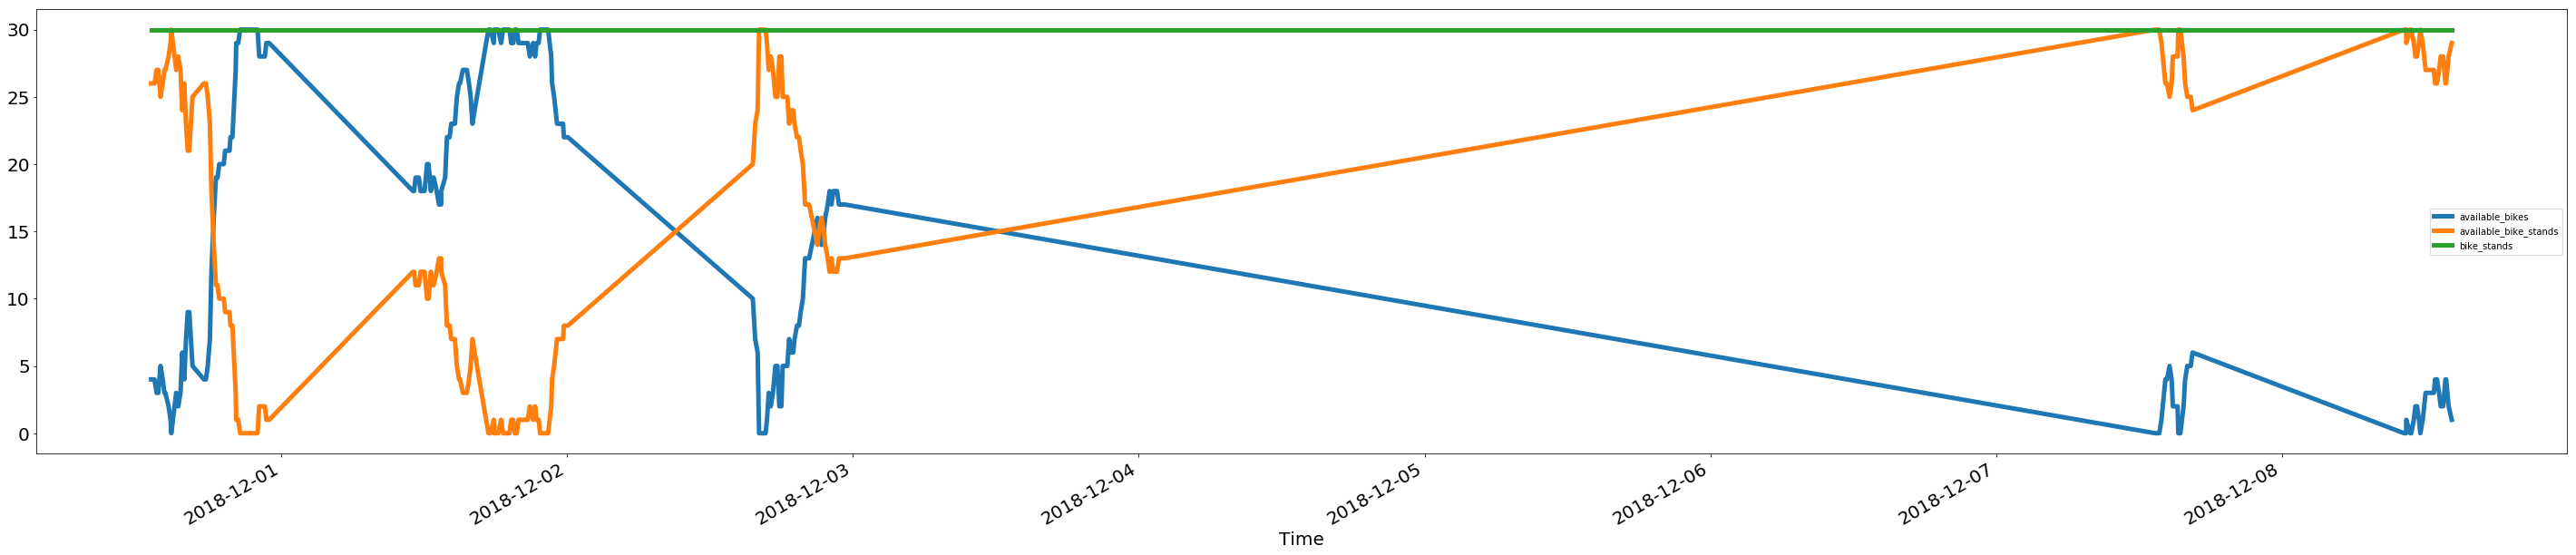

In [23]:
# bike_stands= available_bike_stands + available_bikes 
# So, we only need to predict available_bikes and then compute available_bike_stands
series.plot(figsize=(50,10), linewidth=5, fontsize=20)
plt.xlabel('Time', fontsize=20);

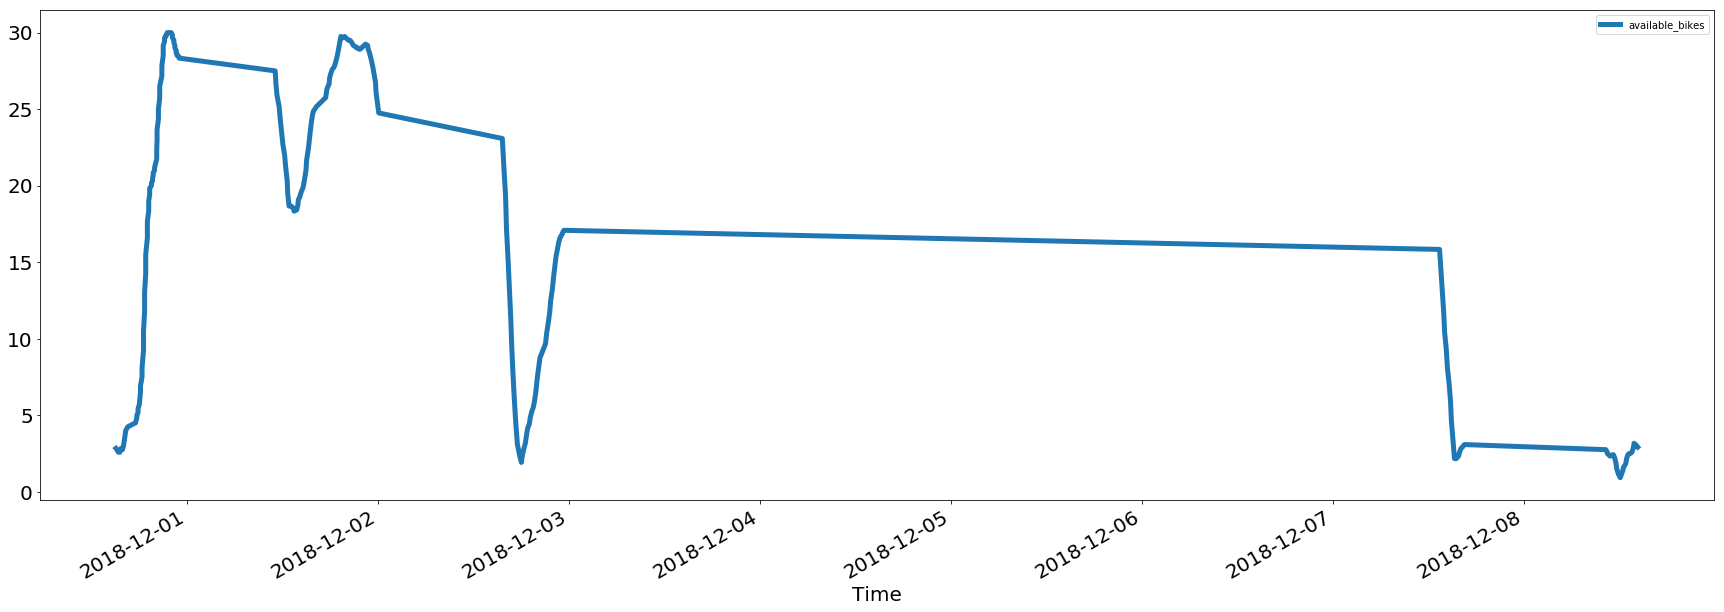

In [25]:
availablebikes= df[['available_bikes']]
availablebikes.rolling(12).mean().plot(figsize=(30,10), linewidth=5, fontsize=20)
plt.xlabel('Time', fontsize=20);

In [26]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [27]:
#reshape the dataset
dataset = availablebikes.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [28]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

167 83


In [30]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [31]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [32]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [33]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.3681
Epoch 2/100
 - 0s - loss: 0.1185
Epoch 3/100
 - 0s - loss: 0.0414
Epoch 4/100
 - 0s - loss: 0.0311
Epoch 5/100
 - 0s - loss: 0.0263
Epoch 6/100
 - 0s - loss: 0.0211
Epoch 7/100
 - 0s - loss: 0.0166
Epoch 8/100
 - 0s - loss: 0.0127
Epoch 9/100
 - 0s - loss: 0.0096
Epoch 10/100
 - 0s - loss: 0.0073
Epoch 11/100
 - 0s - loss: 0.0057
Epoch 12/100
 - 0s - loss: 0.0049
Epoch 13/100
 - 0s - loss: 0.0044
Epoch 14/100
 - 0s - loss: 0.0042
Epoch 15/100
 - 0s - loss: 0.0040
Epoch 16/100
 - 0s - loss: 0.0041
Epoch 17/100
 - 0s - loss: 0.0040
Epoch 18/100
 - 0s - loss: 0.0040
Epoch 19/100
 - 0s - loss: 0.0040
Epoch 20/100
 - 0s - loss: 0.0040
Epoch 21/100
 - 0s - loss: 0.0039
Epoch 22/100
 - 0s - loss: 0.0039
Epoch 23/100
 - 0s - loss: 0.0040
Epoch 24/100
 - 0s - loss: 0.0039
Epoch 25/100
 - 0s - loss: 0.0040
Epoch 26/100
 - 0s - loss: 0.0039
Epoch 27/100
 - 0s - loss: 0.0039
Epoch 28/100
 - 0s - loss: 0.0040
Epoch 29/100
 - 0s - loss: 0.0040
Epoch 30/100
 - 0s - lo

In [34]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.91 RMSE
Test Score: 2.31 RMSE


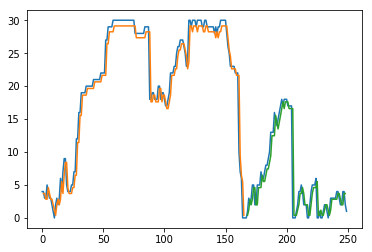

In [35]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In blue, we have the original data ( available bikes).
In orange, it's the prediction of available bike on trainig set.
In Green, it's the prediction of available bikes on test set. 

In [36]:
#train and test for all stations 


def create_dataset(dataset, look_back=1):
    
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)


def apply_modele(data):
    availablebikes= data[['available_bikes']]
    numpy.random.seed(7)
    look_back = 1
    modele = Sequential()
    modele.add(LSTM(4, input_shape=(1, look_back)))
    modele.add(Dense(1))
    modele.compile(loss='mean_squared_error', optimizer='adam')
    dataset = availablebikes.values
    dataset = dataset.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    train_size = int(len(dataset) * 0.67) 
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    modele.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)
    trainPredict = modele.predict(trainX)
    testPredict = modele.predict(testX)
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    return(testPredict,trainScore,testScore)

In [37]:
Prediction=[]
scoretrain=[]
scoretest=[]
stationid=db.dublin.distinct( "number" )
for st in stationid:
    dataset=data[data.number==st]
    testPredict,trainScore,testScore=apply_modele(dataset)
    Prediction.append(testPredict[len(testPredict)-1])
    scoretrain.append(trainScore)
    scoretest.append(testScore)

Epoch 1/50
165/165 [==============================] - 1s 4ms/step - loss: 0.3684
Epoch 2/50
165/165 [==============================] - 0s 2ms/step - loss: 0.1187
Epoch 3/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0415
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0311
Epoch 5/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0263
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 7/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 8/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 9/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 10/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 11/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 12/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 13/50
165/165 [====

165/165 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 1/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0782
Epoch 2/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0619
Epoch 3/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0525
Epoch 4/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0427
Epoch 5/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0338
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0241
Epoch 7/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 8/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 9/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 10/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 11/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 12/50
165/165 [================

165/165 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 50/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 1/50
165/165 [==============================] - 1s 6ms/step - loss: 0.0476
Epoch 2/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 3/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 5/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 7/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 8/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 9/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 10/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 11/50
165/165 [================

165/165 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 1/50
165/165 [==============================] - 1s 7ms/step - loss: 0.0793
Epoch 2/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0351
Epoch 3/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0255
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 5/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 6/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 7/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 8/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 9/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 10/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 11/50
165/165 [================

165/165 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 49/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 50/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 1/50
165/165 [==============================] - 1s 7ms/step - loss: 0.3023
Epoch 2/50
165/165 [==============================] - 0s 2ms/step - loss: 0.1091
Epoch 3/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0488
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 5/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0267
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 7/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 8/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 9/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 10/50
165/165 [================

165/165 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 49/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 50/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 1/50
165/165 [==============================] - 1s 8ms/step - loss: 0.0873
Epoch 2/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0633
Epoch 3/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0531
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0434
Epoch 5/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0345
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0253
Epoch 7/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 8/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 9/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 10/50
165/165 [================

165/165 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 1/50
165/165 [==============================] - 2s 9ms/step - loss: 0.3617
Epoch 2/50
165/165 [==============================] - 0s 2ms/step - loss: 0.1171
Epoch 3/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0420
Epoch 4/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0311
Epoch 5/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 7/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 8/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 9/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 10/50
165/165 [================

165/165 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 49/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0142
Epoch 50/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0146
Epoch 1/50
165/165 [==============================] - 2s 13ms/step - loss: 0.0739
Epoch 2/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0399
Epoch 3/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0316
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0260
Epoch 5/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0208A: 0s - loss:
Epoch 6/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 7/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0111
Epoch 8/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 9/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 10/50
165/165 [==

165/165 [==============================] - 1s 3ms/step - loss: 0.0089
Epoch 48/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0090
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 1/50
165/165 [==============================] - 2s 11ms/step - loss: 0.2727
Epoch 2/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0654
Epoch 3/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 4/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0182
Epoch 5/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0172
Epoch 6/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0164
Epoch 7/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0155
Epoch 8/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 9/50
165/165 [===============

165/165 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 47/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 48/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 49/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 50/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 1/50
165/165 [==============================] - 2s 11ms/step - loss: 0.2265
Epoch 2/50
165/165 [==============================] - 0s 2ms/step - loss: 0.1073
Epoch 3/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0655
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0534
Epoch 5/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0452
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0385
Epoch 7/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0327
Epoch 8/50
165/165 [==============

165/165 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 47/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0056
Epoch 48/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0055
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 1/50
165/165 [==============================] - 3s 16ms/step - loss: 0.1183
Epoch 2/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0411
Epoch 3/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0265
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 5/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 7/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0124
Epoch 8/50
165/165 [==============

165/165 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 47/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 48/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 49/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 50/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0032
Epoch 1/50
165/165 [==============================] - 3s 16ms/step - loss: 0.1852
Epoch 2/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0541
Epoch 3/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0253
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 5/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 6/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 7/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 8/50
165/165 [==============

165/165 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 47/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 48/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 49/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 50/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 1/50
165/165 [==============================] - 3s 16ms/step - loss: 0.0625
Epoch 2/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0434
Epoch 3/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0361
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0293
Epoch 5/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0228
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 7/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 8/50
165/165 [==============

165/165 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 47/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 48/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 50/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0064
Epoch 1/50
165/165 [==============================] - 3s 16ms/step - loss: 0.2463
Epoch 2/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0849
Epoch 3/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0397
Epoch 4/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0306
Epoch 5/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0246
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 7/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 8/50
165/165 [==============

165/165 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 47/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 48/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0043
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 1/50
165/165 [==============================] - 3s 17ms/step - loss: 0.0112
Epoch 2/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0090
Epoch 3/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0080
Epoch 4/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0067
Epoch 5/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0055
Epoch 6/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 7/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0034
Epoch 8/50
165/165 [==============

165/165 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 47/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 48/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 49/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 1/50
165/165 [==============================] - 3s 16ms/step - loss: 0.2653
Epoch 2/50
165/165 [==============================] - 1s 4ms/step - loss: 0.1304
Epoch 3/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0755
Epoch 4/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0523
Epoch 5/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0354
Epoch 6/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0212
Epoch 7/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 8/50
165/165 [==============

165/165 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 47/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0017
Epoch 48/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0017
Epoch 49/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 50/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 1/50
165/165 [==============================] - 3s 19ms/step - loss: 0.3505
Epoch 2/50
165/165 [==============================] - 0s 3ms/step - loss: 0.1062
Epoch 3/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0361
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 5/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 7/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 8/50
165/165 [==============

165/165 [==============================] - 0s 3ms/step - loss: 4.9246e-04
Epoch 45/50
165/165 [==============================] - 0s 2ms/step - loss: 4.9742e-04
Epoch 46/50
165/165 [==============================] - 0s 2ms/step - loss: 5.3547e-04
Epoch 47/50
165/165 [==============================] - 0s 2ms/step - loss: 5.1200e-04
Epoch 48/50
165/165 [==============================] - 0s 2ms/step - loss: 4.9471e-04
Epoch 49/50
165/165 [==============================] - 0s 2ms/step - loss: 5.1377e-04
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 5.2461e-04
Epoch 1/50
165/165 [==============================] - 3s 19ms/step - loss: 0.3740
Epoch 2/50
165/165 [==============================] - 0s 3ms/step - loss: 0.1066
Epoch 3/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0336
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0274
Epoch 5/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0249
Epoc

165/165 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 44/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 45/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 46/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 47/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 48/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 50/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 1/50
165/165 [==============================] - 3s 20ms/step - loss: 0.0421
Epoch 2/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0360
Epoch 3/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0322
Epoch 4/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0277
Epoch 5/50
165/165 [===========

165/165 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 44/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 45/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 46/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 47/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 48/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 1/50
165/165 [==============================] - 3s 19ms/step - loss: 0.2657
Epoch 2/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0775
Epoch 3/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0303
Epoch 4/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 5/50
165/165 [===========

165/165 [==============================] - 1s 4ms/step - loss: 0.0054
Epoch 44/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 45/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 46/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 47/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 48/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0052
Epoch 49/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0053
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 1/50
165/165 [==============================] - 3s 21ms/step - loss: 0.1983
Epoch 2/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0993
Epoch 3/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0623
Epoch 4/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0449
Epoch 5/50
165/165 [===========

165/165 [==============================] - 1s 6ms/step - loss: 0.0029 ETA: 1s -
Epoch 43/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0028
Epoch 44/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0029
Epoch 45/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 46/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 47/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0029
Epoch 48/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 1/50
165/165 [==============================] - 4s 23ms/step - loss: 0.1462
Epoch 2/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0615
Epoch 3/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0388
Epoch 4/50
165/165 [

165/165 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 42/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 43/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 44/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 45/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 46/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 47/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 48/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 50/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 1/50
165/165 [==============================] - 4s 22ms/step - loss: 0.1033
Epoch 2/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 3/50
165/165 [=========

165/165 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 42/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 43/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 44/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0067
Epoch 45/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 46/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0068
Epoch 47/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0068
Epoch 48/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0067
Epoch 49/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1/50
165/165 [==============================] - 4s 24ms/step - loss: 0.1302
Epoch 2/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0674
Epoch 3/50
165/165 [=========

165/165 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 42/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 43/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 44/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 45/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 46/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 47/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 48/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 1/50
165/165 [==============================] - 4s 23ms/step - loss: 0.1339
Epoch 2/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0583
Epoch 3/50
165/165 [=========

165/165 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 41/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 42/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 43/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 44/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 45/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 46/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 47/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 48/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 1/50
165/165 [==============================] - 4s 26ms/step - loss: 0.0686
Epoch 2/50
165/165 [========

165/165 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 41/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 42/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 43/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 44/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 45/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 46/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 47/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 48/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 1/50
165/165 [==============================] - 5s 30ms/step - loss: 0.2970
Epoch 2/50
165/165 [========

165/165 [==============================] - 1s 5ms/step - loss: 0.0047
Epoch 41/50
165/165 [==============================] - 1s 6ms/step - loss: 0.0045
Epoch 42/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 43/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0046A: 0s - loss: 0.00
Epoch 44/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 45/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 46/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 47/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 48/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 49/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 50/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1/50
165/165 [==============================] - 6s 33ms/step - loss: 0.2299
Epoch 2/50

165/165 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 40/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 41/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 42/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 43/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 44/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 45/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 46/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 47/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 48/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 1/50
165/165 [========

165/165 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 40/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 41/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 42/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 43/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 44/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 45/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 46/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 47/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 48/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 50/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 1/50
165/165 [========

165/165 [==============================] - 1s 3ms/step - loss: 0.0018
Epoch 40/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 41/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 42/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 43/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 44/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 45/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 46/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 47/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 48/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 49/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 50/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 1/50
165/165 [========

165/165 [==============================] - 1s 5ms/step - loss: 0.0036
Epoch 40/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0037
Epoch 41/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 42/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 43/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0036
Epoch 44/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0037
Epoch 45/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0036
Epoch 46/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0037
Epoch 47/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0036
Epoch 48/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0036
Epoch 49/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0036
Epoch 50/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0036
Epoch 1/50
165/165 [========

165/165 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 39/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 40/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 41/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 42/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 43/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 44/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 45/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 46/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 47/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 48/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 50/50
165/165 [=======

165/165 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 39/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 40/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 41/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 42/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 43/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 44/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 45/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 46/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 47/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 48/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 50/50
165/165 [=======

165/165 [==============================] - 1s 3ms/step - loss: 0.0026
Epoch 39/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 40/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 41/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 42/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 43/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 44/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 45/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 46/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 47/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0025A: 0s - loss: 0.00
Epoch 48/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0025
Epoch 49/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 50/5

165/165 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 38/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 39/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 40/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 41/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 42/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 43/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 44/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 45/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 46/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 47/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 48/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 49/50
165/165 [=======

165/165 [==============================] - 1s 3ms/step - loss: 5.9913e-04
Epoch 37/50
165/165 [==============================] - 1s 3ms/step - loss: 5.9979e-04
Epoch 38/50
165/165 [==============================] - 1s 3ms/step - loss: 6.0071e-04
Epoch 39/50
165/165 [==============================] - 1s 3ms/step - loss: 6.0189e-04
Epoch 40/50
165/165 [==============================] - 1s 3ms/step - loss: 5.9733e-04
Epoch 41/50
165/165 [==============================] - 1s 3ms/step - loss: 5.9200e-04
Epoch 42/50
165/165 [==============================] - 0s 3ms/step - loss: 5.9020e-04
Epoch 43/50
165/165 [==============================] - 0s 3ms/step - loss: 5.9956e-04
Epoch 44/50
165/165 [==============================] - 1s 3ms/step - loss: 6.0635e-04
Epoch 45/50
165/165 [==============================] - 1s 3ms/step - loss: 6.0530e-04
Epoch 46/50
165/165 [==============================] - 1s 3ms/step - loss: 5.9329e-04
Epoch 47/50
165/165 [==============================] - 1s 3ms/step

165/165 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 35/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 36/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 37/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 38/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 39/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 40/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 41/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 42/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 43/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 44/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 45/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 46/50
165/165 [=======

165/165 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 35/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 36/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 37/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 38/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 39/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 40/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 41/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 42/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 43/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 44/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 45/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 46/50
165/165 [=======

165/165 [==============================] - 1s 3ms/step - loss: 0.0117
Epoch 35/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0113
Epoch 36/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0118
Epoch 37/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0116
Epoch 38/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0117
Epoch 39/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0115
Epoch 40/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0117
Epoch 41/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0116
Epoch 42/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0117
Epoch 43/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0116
Epoch 44/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0115
Epoch 45/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0116
Epoch 46/50
165/165 [=======

165/165 [==============================] - 1s 7ms/step - loss: 0.0069
Epoch 34/50
165/165 [==============================] - 1s 8ms/step - loss: 0.0067
Epoch 35/50
165/165 [==============================] - 1s 9ms/step - loss: 0.0068
Epoch 36/50
165/165 [==============================] - 1s 7ms/step - loss: 0.0069
Epoch 37/50
165/165 [==============================] - 1s 8ms/step - loss: 0.0069
Epoch 38/50
165/165 [==============================] - 1s 7ms/step - loss: 0.0069
Epoch 39/50
165/165 [==============================] - 1s 8ms/step - loss: 0.0068
Epoch 40/50
165/165 [==============================] - 1s 6ms/step - loss: 0.0067
Epoch 41/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0068
Epoch 42/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0068
Epoch 43/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0067
Epoch 44/50
165/165 [==============================] - 1s 6ms/step - loss: 0.0069
Epoch 45/50
165/165 [=======

165/165 [==============================] - 1s 4ms/step - loss: 0.0068
Epoch 33/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0068
Epoch 34/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0068
Epoch 35/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0068
Epoch 36/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0067
Epoch 37/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0068
Epoch 38/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0067
Epoch 39/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0067
Epoch 40/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0068
Epoch 41/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0067
Epoch 42/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0068
Epoch 43/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0068
Epoch 44/50
165/165 [=======

165/165 [==============================] - 1s 4ms/step - loss: 0.0119
Epoch 33/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0118
Epoch 34/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0119
Epoch 35/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0117
Epoch 36/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0120
Epoch 37/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0120
Epoch 38/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0119
Epoch 39/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0118
Epoch 40/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0118
Epoch 41/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0119
Epoch 42/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0120
Epoch 43/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0118
Epoch 44/50
165/165 [=======

165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 33/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 34/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 35/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 36/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 37/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 38/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 39/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 40/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 41/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 42/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 43/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 44/50
165/165 [=======

165/165 [==============================] - 1s 4ms/step - loss: 0.0020
Epoch 32/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0020
Epoch 33/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0020
Epoch 34/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0020
Epoch 35/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 36/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0020
Epoch 37/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0020
Epoch 38/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0020
Epoch 39/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0020
Epoch 40/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 41/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 42/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0020
Epoch 43/50
165/165 [=======

165/165 [==============================] - 1s 4ms/step - loss: 0.0064
Epoch 31/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0064
Epoch 32/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0064
Epoch 33/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0064
Epoch 34/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0065
Epoch 35/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0064
Epoch 36/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0064
Epoch 37/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0064
Epoch 38/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0065
Epoch 39/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0064
Epoch 40/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0065
Epoch 41/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0064
Epoch 42/50
165/165 [=======

165/165 [==============================] - 1s 4ms/step - loss: 0.0076
Epoch 30/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0076
Epoch 31/50
165/165 [==============================] - 1s 7ms/step - loss: 0.0075
Epoch 32/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0076
Epoch 33/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0075
Epoch 34/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0077
Epoch 35/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0077
Epoch 36/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0076
Epoch 37/50
165/165 [==============================] - 1s 6ms/step - loss: 0.0076
Epoch 38/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0075
Epoch 39/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0076
Epoch 40/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0075
Epoch 41/50
165/165 [=======

165/165 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 29/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 30/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 31/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 32/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0015
Epoch 33/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 34/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0014
Epoch 35/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0014
Epoch 36/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 37/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 38/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 39/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0015
Epoch 40/50
165/165 [=======

165/165 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 28/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 29/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 30/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 31/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 32/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 33/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 34/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 35/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 36/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 37/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 38/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 39/50
165/165 [=======

165/165 [==============================] - 1s 5ms/step - loss: 0.0098
Epoch 28/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0098
Epoch 29/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0099
Epoch 30/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0098
Epoch 31/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0098
Epoch 32/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0098
Epoch 33/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0098
Epoch 34/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0098
Epoch 35/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0097
Epoch 36/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0099
Epoch 37/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0099
Epoch 38/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0098
Epoch 39/50
165/165 [=======

165/165 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 27/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 28/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 29/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 30/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 31/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 32/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 33/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 34/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 35/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 36/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 37/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 38/50
165/165 [=======

165/165 [==============================] - 1s 4ms/step - loss: 0.0060
Epoch 27/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0059
Epoch 28/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0060
Epoch 29/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0059
Epoch 30/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0060
Epoch 31/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0060
Epoch 32/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0060
Epoch 33/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0060
Epoch 34/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0060
Epoch 35/50
165/165 [==============================] - 1s 7ms/step - loss: 0.0059
Epoch 36/50
165/165 [==============================] - 1s 6ms/step - loss: 0.0059
Epoch 37/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0060
Epoch 38/50
165/165 [=======

165/165 [==============================] - 1s 4ms/step - loss: 0.0023
Epoch 26/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0023
Epoch 27/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0023
Epoch 28/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0023
Epoch 29/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0023
Epoch 30/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0023
Epoch 31/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0023
Epoch 32/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0024
Epoch 33/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0022
Epoch 34/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0023
Epoch 35/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0022
Epoch 36/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0022
Epoch 37/50
165/165 [=======

165/165 [==============================] - 1s 4ms/step - loss: 0.0057
Epoch 26/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0057
Epoch 27/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0057
Epoch 28/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 29/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 30/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0057
Epoch 31/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0057
Epoch 32/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0057
Epoch 33/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0057
Epoch 34/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0057
Epoch 35/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0057
Epoch 36/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0057
Epoch 37/50
165/165 [=======

165/165 [==============================] - 1s 4ms/step - loss: 0.0073
Epoch 25/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0072
Epoch 26/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0073
Epoch 27/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0071
Epoch 28/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0072
Epoch 29/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0073
Epoch 30/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0072
Epoch 31/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0072
Epoch 32/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0073
Epoch 33/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0073
Epoch 34/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0073
Epoch 35/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0073
Epoch 36/50
165/165 [=======

165/165 [==============================] - 1s 8ms/step - loss: 0.0050
Epoch 24/50
165/165 [==============================] - 1s 8ms/step - loss: 0.0050
Epoch 25/50
165/165 [==============================] - 1s 7ms/step - loss: 0.0050
Epoch 26/50
165/165 [==============================] - 1s 6ms/step - loss: 0.0051A: 0s - loss:
Epoch 27/50
165/165 [==============================] - 1s 6ms/step - loss: 0.0050
Epoch 28/50
165/165 [==============================] - 1s 6ms/step - loss: 0.0049
Epoch 29/50
165/165 [==============================] - 1s 7ms/step - loss: 0.0050
Epoch 30/50
165/165 [==============================] - 1s 7ms/step - loss: 0.0050
Epoch 31/50
165/165 [==============================] - 1s 7ms/step - loss: 0.0050
Epoch 32/50
165/165 [==============================] - 1s 6ms/step - loss: 0.0049
Epoch 33/50
165/165 [==============================] - 1s 6ms/step - loss: 0.0050
Epoch 34/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0050
Epoch 35/50
165

165/165 [==============================] - 1s 5ms/step - loss: 0.0039
Epoch 23/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0039
Epoch 24/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0038
Epoch 25/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0039- ETA: 0s - loss: 4.8
Epoch 26/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0038
Epoch 27/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0038
Epoch 28/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0038
Epoch 29/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0037
Epoch 30/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0037
Epoch 31/50
165/165 [==============================] - 1s 4ms/step - loss: 0.0038
Epoch 32/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0038
Epoch 33/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0038
Epoch 3

165/165 [==============================] - 1s 5ms/step - loss: 0.0041
Epoch 22/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 23/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0041
Epoch 24/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0042
Epoch 25/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0041
Epoch 26/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0041
Epoch 27/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 28/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0041
Epoch 29/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 30/50
165/165 [==============================] - ETA: 0s - loss: 0.003 - 1s 5ms/step - loss: 0.0040
Epoch 31/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0041
Epoch 32/50
165/165 [==============================] - 1s 5ms/step - loss: 0.0041
Epoc

In [42]:
# Comparing RMSE scores on Train and Test for all the stations
trainScore=pd.DataFrame(scoretrain)
testScore=pd.DataFrame(scoretest)
RMSEScore=pd.concat((trainScore,testScore),axis=1)
RMSEScore.columns=["Train","Test"]
RMSEScore.index= stationid
RMSEScore

,Train,Test
42,1.845286,2.325495
30,0.900009,1.133551
54,1.195709,1.464269
108,0.783998,0.745222
56,2.410080,4.408776
6,1.020102,2.372153
18,1.544678,3.212946
32,2.694478,2.144250
52,1.620165,2.276038
48,2.066666,2.246248


In [44]:
           #preparing data with the id and name of stations and their gps poistions  
result1=pd.DataFrame(db.dublin.distinct( "position" ))
result2=pd.DataFrame(db.dublin.distinct( "name" ))
result3=pd.DataFrame(db.dublin.distinct( "number" ))
resultstation=pd.concat([result2,result3,result1],axis=1)
resultstation.columns=['name','number','lat','lng']
resultstation

,name,number,lat,lng
0,SMITHFIELD NORTH,42,53.349562,-6.278198
1,PARNELL SQUARE NORTH,30,53.353462,-6.265305
2,CLONMEL STREET,54,53.336021,-6.262980
3,AVONDALE ROAD,108,53.359405,-6.276142
4,MOUNT STREET LOWER,56,53.337960,-6.241530
5,CHRISTCHURCH PLACE,6,53.343368,-6.270120
6,GRANTHAM STREET,18,53.334123,-6.265436
7,PEARSE STREET,32,53.344304,-6.250427
8,YORK STREET EAST,52,53.338755,-6.262003
9,EXCISE WALK,48,53.347777,-6.244239


In [45]:
#add prediction of avialable bikes  to stations' data 
resultstation['prediction']=Prediction
resultstation

,name,number,lat,lng,prediction
0,SMITHFIELD NORTH,42,53.349562,-6.278198,[4.312433]
1,PARNELL SQUARE NORTH,30,53.353462,-6.265305,[1.9610468]
2,CLONMEL STREET,54,53.336021,-6.262980,[6.09739]
3,AVONDALE ROAD,108,53.359405,-6.276142,[0.12918887]
4,MOUNT STREET LOWER,56,53.337960,-6.241530,[7.9139366]
5,CHRISTCHURCH PLACE,6,53.343368,-6.270120,[19.93164]
6,GRANTHAM STREET,18,53.334123,-6.265436,[28.979242]
7,PEARSE STREET,32,53.344304,-6.250427,[28.275171]
8,YORK STREET EAST,52,53.338755,-6.262003,[30.917995]
9,EXCISE WALK,48,53.347777,-6.244239,[21.926533]


In [46]:
#Function that computes the distance between a (user's)gps position and the stations

#coputing distance 

def distancegps(coordonnes):
    distance=[]
    result=resultstation
    for i in range (resultstation.shape[0]):
        coord=(resultstation.iloc[i,2]  ,resultstation.iloc[i,3])
        distance.append(vincenty(coordonnes, coord))
    result['distance']=distance
    return(result)



#user's gps position (latitude and longitude( 5 and 6 for example)

lat= 5
lng=6
coordonnes=(lat,lng)

# 3 nearest station to the user and available bikes per station

table=distancegps(coordonnes)
sortedistance=table.sort_values(['distance'])
max3=sortedistance.iloc[0:3,:]
max3

C:\Users\ybellalah\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  # Remove the CWD from sys.path while we load stuff.


,name,number,lat,lng,prediction,distance
38,CHARLEMONT PLACE,5,53.330662,-6.260177,[4.7309546],5474.104786121129 km
109,WILTON TERRACE,39,53.332383,-6.252717,[0.55936843],5474.149725177153 km
79,PORTOBELLO HARBOUR,34,53.330362,-6.265163,[11.450303],5474.165653574721 km
